In [1]:
import torch
import torch.nn as nn
from torchvision import transforms, models
from PIL import Image
from tqdm import tqdm
import os
import numpy as np
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import pandas as pd
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
imsize = 224 if torch.cuda.is_available() else 128


/Users/samarthuday/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        # Keep your original deeper feature layers
        self.chosen_features = ["0", "5", "10", "19", "28"]
        self.model = models.vgg19(pretrained=True).features[:29].eval()
    
    def forward(self, x):
        features = []
        for layer_num, layer in enumerate(self.model):
            x = layer(x)
            if str(layer_num) in self.chosen_features:
                features.append(x)
        return features
class SoftClamp(nn.Module):
    def forward(self, image):
        return (torch.tanh(3 * image - 1.5) + 1) / 2.0
loader = transforms.Compose([
    transforms.Resize((imsize, imsize)),
    transforms.ToTensor(),
])

unloader = transforms.Compose([
    SoftClamp(),
    transforms.ToPILImage()
])


In [3]:
def load_image(file_path):
    image = Image.open(file_path).convert("RGB")
    image = loader(image).unsqueeze(0)
    return image.to(device)
def save_image(tensor, file_name):
    folder = "/Users/samarthuday/Desktop/Git/Art_Style/images/generated/"
    os.makedirs(folder, exist_ok=True)

    file_path = os.path.join(folder, file_name)

    image = tensor.detach().cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    image.save(file_path)

    print(f"Image saved at: {file_path}")
    return file_path
def show_image(tensor):
    image = tensor.detach().cpu().clone().squeeze(0)
    image = unloader(image)
    display(image)


In [4]:
def gram_matrix(tensor):
    _, c, h, w = tensor.size()
    features = tensor.view(c, h*w)
    G = features @ features.t()
    return G / (c*h*w)
def tv_loss(image):
    x = image[:, :, :, 1:] - image[:, :, :, :-1]
    y = image[:, :, 1:, :] - image[:, :, :-1, :]
    return torch.sum(torch.abs(x)) + torch.sum(torch.abs(y))
def compute_metrics(gen_img, content_img):
    g = gen_img.detach().cpu().clamp(0,1).squeeze(0).permute(1,2,0).numpy()
    c = content_img.detach().cpu().clamp(0,1).squeeze(0).permute(1,2,0).numpy()

    psnr = peak_signal_noise_ratio(c, g, data_range=1.0)
    ssim = structural_similarity(c, g, channel_axis=2)
    return psnr, ssim


In [15]:
def run_style_transfer(
        content_img, style_img,
        alpha=1, beta=0.1,
        tv_weight=0.0,
        total_steps=3000,
        lr=0.0005,
        track_every=100):

    vgg = VGG().to(device)

    # ---- IMPORTANT: compute content/style features ONCE, with NO grad graph ----
    with torch.no_grad():
        content_features = vgg(content_img)
        style_features   = vgg(style_img)

    # generated image that we optimize
    generated_img = content_img.clone().requires_grad_(True)
    optimizer = torch.optim.Adam([generated_img], lr=lr)

    history = []

    for step in tqdm(range(total_steps)):
        # features of generated image (this creates a graph we backprop through)
        gen_features = vgg(generated_img)

        content_loss = 0.0
        style_loss = 0.0

        for gf, cf, sf in zip(gen_features, content_features, style_features):
            content_loss = content_loss + torch.mean((gf - cf) ** 2)

            G = gram_matrix(gf)
            A = gram_matrix(sf)
            style_loss = style_loss + torch.mean((G - A) ** 2)

        # TV loss (optional)
        loss_tv = tv_weight * tv_loss(generated_img)

        total_loss = alpha * content_loss + beta * style_loss + loss_tv

        optimizer.zero_grad()
        total_loss.backward()   # ✅ only graph is from generated_img → vgg → losses
        optimizer.step()

        if step % track_every == 0:
            print(f"Step {step}, Total Loss = {total_loss.item():.4f}")
            history.append(generated_img.detach().clone())

    return generated_img.detach(), history


In [16]:
def alpha_beta_sweep(content_img, style_img, alphas, betas,
                     steps=500, tv_weight=0.0):
    
    records = []
    vgg = VGG().to(device)

    for a in alphas:
        for b in betas:
            print(f"\nRunning α={a}, β={b}")
            gen, _ = run_style_transfer(
                content_img, style_img,
                alpha=a, beta=b,
                tv_weight=tv_weight,
                total_steps=steps,
                track_every=steps+1
            )

            psnr, ssim = compute_metrics(gen, content_img)
            out_name = f"ab_a{a}_b{b}.png"
            save_path = save_image(gen, out_name)

            records.append({
                "alpha": a,
                "beta": b,
                "PSNR": psnr,
                "SSIM": ssim,
                "output": save_path
            })

    return pd.DataFrame(records)


In [17]:
def tv_ablation(content_img, style_img, alpha=1, beta=0.1, steps=500):
    configs = [
        ("with_tv", 1e-6),
        ("no_tv", 0.0)
    ]

    records = []
    
    for name, tv_w in configs:
        print(f"\nRunning {name} (tv_weight={tv_w})")

        gen, _ = run_style_transfer(
            content_img, style_img,
            alpha=alpha, beta=beta,
            total_steps=steps,
            tv_weight=tv_w,
            track_every=steps+1
        )

        psnr, ssim = compute_metrics(gen, content_img)
        out_name = f"{name}.png"
        save_path = save_image(gen, out_name)

        records.append({
            "config": name,
            "tv_weight": tv_w,
            "PSNR": psnr,
            "SSIM": ssim,
            "output": save_path
        })

    return pd.DataFrame(records)


Content Image:


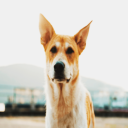

Style Image:


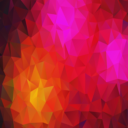

In [9]:
content_file = "/Users/samarthuday/Desktop/art/Art_Style/content/dog.png"
style_file = "/Users/samarthuday/Desktop/art/Art_Style/style/ab4.jpeg"

content_img = load_image(content_file)
style_img = load_image(style_file)

print("Content Image:")
show_image(content_img)

print("Style Image:")
show_image(style_img)


In [18]:
generated_img, history = run_style_transfer(
    content_img, style_img,
    alpha=1, beta=0.1,
    tv_weight=0.0,
    total_steps=3000
)


  0%|          | 2/3000 [00:00<07:02,  7.10it/s]

Step 0, Total Loss = 0.0002


  3%|▎         | 102/3000 [00:12<05:44,  8.40it/s]

Step 100, Total Loss = 0.0003


  7%|▋         | 202/3000 [00:24<05:40,  8.22it/s]

Step 200, Total Loss = 0.0002


 10%|█         | 302/3000 [00:36<05:24,  8.32it/s]

Step 300, Total Loss = 0.0002


 13%|█▎        | 402/3000 [00:48<05:13,  8.28it/s]

Step 400, Total Loss = 0.0002


 17%|█▋        | 502/3000 [01:00<04:58,  8.37it/s]

Step 500, Total Loss = 0.0002


 20%|██        | 602/3000 [01:12<04:48,  8.30it/s]

Step 600, Total Loss = 0.0002


 23%|██▎       | 702/3000 [01:24<04:26,  8.63it/s]

Step 700, Total Loss = 0.0002


 27%|██▋       | 802/3000 [01:37<04:28,  8.18it/s]

Step 800, Total Loss = 0.0002


 30%|███       | 902/3000 [01:49<04:17,  8.14it/s]

Step 900, Total Loss = 0.0002


 33%|███▎      | 1002/3000 [02:01<03:51,  8.65it/s]

Step 1000, Total Loss = 0.0002


 37%|███▋      | 1102/3000 [02:13<03:41,  8.58it/s]

Step 1100, Total Loss = 0.0002


 40%|████      | 1202/3000 [02:25<03:25,  8.75it/s]

Step 1200, Total Loss = 0.0003


 43%|████▎     | 1302/3000 [02:38<03:44,  7.57it/s]

Step 1300, Total Loss = 0.0002


 47%|████▋     | 1402/3000 [02:51<03:27,  7.70it/s]

Step 1400, Total Loss = 0.0002


 50%|█████     | 1502/3000 [03:04<02:58,  8.41it/s]

Step 1500, Total Loss = 0.0006


 53%|█████▎    | 1602/3000 [03:16<02:57,  7.89it/s]

Step 1600, Total Loss = 0.0002


 57%|█████▋    | 1702/3000 [03:29<02:48,  7.71it/s]

Step 1700, Total Loss = 0.0003


 60%|██████    | 1802/3000 [03:42<02:28,  8.08it/s]

Step 1800, Total Loss = 0.0002


 63%|██████▎   | 1902/3000 [03:54<02:15,  8.09it/s]

Step 1900, Total Loss = 0.0002


 67%|██████▋   | 2002/3000 [04:08<02:08,  7.78it/s]

Step 2000, Total Loss = 0.0002


 70%|███████   | 2102/3000 [04:20<01:48,  8.27it/s]

Step 2100, Total Loss = 0.0002


 73%|███████▎  | 2202/3000 [04:32<01:37,  8.15it/s]

Step 2200, Total Loss = 0.0002


 77%|███████▋  | 2302/3000 [04:45<01:36,  7.25it/s]

Step 2300, Total Loss = 0.0002


 80%|████████  | 2402/3000 [04:58<01:13,  8.08it/s]

Step 2400, Total Loss = 0.0002


 83%|████████▎ | 2502/3000 [05:11<01:01,  8.05it/s]

Step 2500, Total Loss = 0.0002


 87%|████████▋ | 2602/3000 [05:23<00:48,  8.19it/s]

Step 2600, Total Loss = 0.0002


 90%|█████████ | 2702/3000 [05:36<00:37,  8.02it/s]

Step 2700, Total Loss = 0.0003


 93%|█████████▎| 2802/3000 [05:48<00:24,  8.25it/s]

Step 2800, Total Loss = 0.0002


 97%|█████████▋| 2902/3000 [06:01<00:13,  7.25it/s]

Step 2900, Total Loss = 0.0003


100%|██████████| 3000/3000 [06:14<00:00,  8.00it/s]


In [19]:
save_path = save_image(generated_img, "generated2.png")

psnr, ssim = compute_metrics(generated_img, content_img)
print(f"PSNR: {psnr:.3f}   SSIM: {ssim:.3f}")


Image saved at: /Users/samarthuday/Desktop/Git/Art_Style/images/generated/generated2.png
PSNR: 61.854   SSIM: 1.000


In [20]:
df_sweep = alpha_beta_sweep(
    content_img, style_img,
    alphas=[0.1, 1, 2],
    betas=[0.05, 0.1, 0.5],
    steps=400
)

df_sweep



Running α=0.1, β=0.05


  0%|          | 2/400 [00:00<00:49,  7.97it/s]

Step 0, Total Loss = 0.0001


100%|██████████| 400/400 [00:49<00:00,  8.12it/s]


Image saved at: /Users/samarthuday/Desktop/Git/Art_Style/images/generated/ab_a0.1_b0.05.png

Running α=0.1, β=0.1


  0%|          | 2/400 [00:00<00:48,  8.27it/s]

Step 0, Total Loss = 0.0002


100%|██████████| 400/400 [00:49<00:00,  8.12it/s]


Image saved at: /Users/samarthuday/Desktop/Git/Art_Style/images/generated/ab_a0.1_b0.1.png

Running α=0.1, β=0.5


  0%|          | 2/400 [00:00<00:48,  8.19it/s]

Step 0, Total Loss = 0.0010


100%|██████████| 400/400 [00:48<00:00,  8.29it/s]


Image saved at: /Users/samarthuday/Desktop/Git/Art_Style/images/generated/ab_a0.1_b0.5.png

Running α=1, β=0.05


  0%|          | 2/400 [00:00<00:51,  7.78it/s]

Step 0, Total Loss = 0.0001


100%|██████████| 400/400 [00:49<00:00,  8.11it/s]


Image saved at: /Users/samarthuday/Desktop/Git/Art_Style/images/generated/ab_a1_b0.05.png

Running α=1, β=0.1


  0%|          | 2/400 [00:00<01:07,  5.90it/s]

Step 0, Total Loss = 0.0002


100%|██████████| 400/400 [00:50<00:00,  7.95it/s]


Image saved at: /Users/samarthuday/Desktop/Git/Art_Style/images/generated/ab_a1_b0.1.png

Running α=1, β=0.5


  0%|          | 2/400 [00:00<00:58,  6.86it/s]

Step 0, Total Loss = 0.0010


100%|██████████| 400/400 [00:51<00:00,  7.72it/s]


Image saved at: /Users/samarthuday/Desktop/Git/Art_Style/images/generated/ab_a1_b0.5.png

Running α=2, β=0.05


  0%|          | 2/400 [00:00<01:21,  4.89it/s]

Step 0, Total Loss = 0.0001


100%|██████████| 400/400 [00:50<00:00,  7.94it/s]


Image saved at: /Users/samarthuday/Desktop/Git/Art_Style/images/generated/ab_a2_b0.05.png

Running α=2, β=0.1


  0%|          | 2/400 [00:00<00:49,  8.07it/s]

Step 0, Total Loss = 0.0002


100%|██████████| 400/400 [00:49<00:00,  8.06it/s]


Image saved at: /Users/samarthuday/Desktop/Git/Art_Style/images/generated/ab_a2_b0.1.png

Running α=2, β=0.5


  0%|          | 2/400 [00:00<00:55,  7.12it/s]

Step 0, Total Loss = 0.0010


100%|██████████| 400/400 [00:50<00:00,  7.90it/s]


Image saved at: /Users/samarthuday/Desktop/Git/Art_Style/images/generated/ab_a2_b0.5.png


,alpha,beta,PSNR,SSIM,output
0,0.1,0.05,66.484933,0.999960,/Users/samarthuday/Desktop/Git/Art_Style/image...
1,0.1,0.10,66.329798,0.999958,/Users/samarthuday/Desktop/Git/Art_Style/image...
2,0.1,0.50,66.323540,0.999958,/Users/samarthuday/Desktop/Git/Art_Style/image...
3,1.0,0.05,66.469830,0.999960,/Users/samarthuday/Desktop/Git/Art_Style/image...
4,1.0,0.10,66.295322,0.999958,/Users/samarthuday/Desktop/Git/Art_Style/image...
5,1.0,0.50,66.291346,0.999958,/Users/samarthuday/Desktop/Git/Art_Style/image...
6,2.0,0.05,66.457272,0.999959,/Users/samarthuday/Desktop/Git/Art_Style/image...
7,2.0,0.10,66.297698,0.999958,/Users/samarthuday/Desktop/Git/Art_Style/image...
8,2.0,0.50,66.252536,0.999957,/Users/samarthuday/Desktop/Git/Art_Style/image...


In [ ]:
df_tv = tv_ablation(
    content_img, style_img,
    alpha=1, beta=0.1,
    steps=400
)

df_tv



Running with_tv (tv_weight=1e-06)


/Users/samarthuday/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/samarthuday/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0%|          | 2/400 [00:00<00:58,  6.81it/s]

Step 0, Total Loss = 0.0020


 42%|████▏     | 167/400 [00:21<00:31,  7.51it/s]

Content Image:


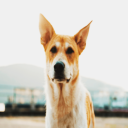

Style Image:


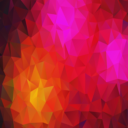

  0%|          | 0/3000 [00:00<?, ?it/s]

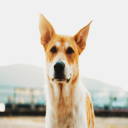

  3%|▎         | 100/3000 [01:33<44:34,  1.08it/s]

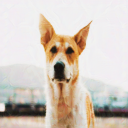

  7%|▋         | 200/3000 [03:07<42:03,  1.11it/s]  

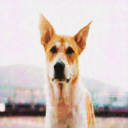

 10%|█         | 300/3000 [04:47<47:56,  1.07s/it]

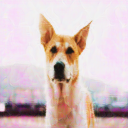

 13%|█▎        | 400/3000 [06:22<39:18,  1.10it/s]

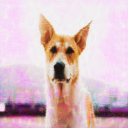

 17%|█▋        | 500/3000 [07:55<39:57,  1.04it/s]

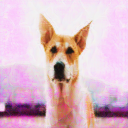

 20%|██        | 600/3000 [09:27<37:33,  1.07it/s]

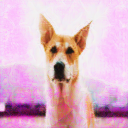

 23%|██▎       | 700/3000 [11:04<36:39,  1.05it/s]

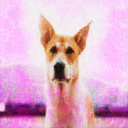

 27%|██▋       | 800/3000 [12:45<34:15,  1.07it/s]

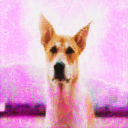

 30%|███       | 900/3000 [14:24<31:57,  1.10it/s]

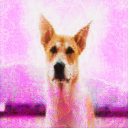

 33%|███▎      | 1000/3000 [16:02<31:16,  1.07it/s]

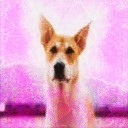

 37%|███▋      | 1100/3000 [17:40<38:56,  1.23s/it]

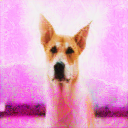

 40%|████      | 1200/3000 [19:38<28:14,  1.06it/s]  

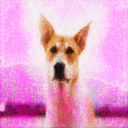

 43%|████▎     | 1300/3000 [21:19<28:05,  1.01it/s]

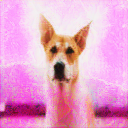

 47%|████▋     | 1400/3000 [22:53<26:09,  1.02it/s]

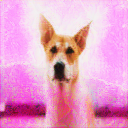

 50%|█████     | 1500/3000 [24:29<21:58,  1.14it/s]

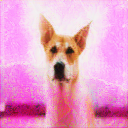

 53%|█████▎    | 1600/3000 [48:14<18:37:27, 47.89s/it]  

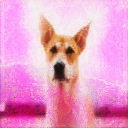

 57%|█████▋    | 1700/3000 [2:54:56<20:04,  1.08it/s]     

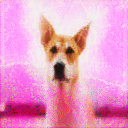

 60%|██████    | 1800/3000 [3:00:47<43:17,  2.16s/it]   

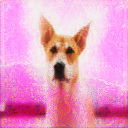

 63%|██████▎   | 1900/3000 [3:02:34<18:19,  1.00it/s]

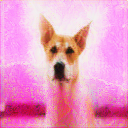

 67%|██████▋   | 2000/3000 [3:04:08<14:51,  1.12it/s]

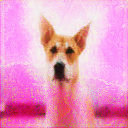

 70%|███████   | 2100/3000 [3:05:41<13:47,  1.09it/s]

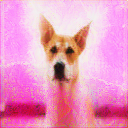

 73%|███████▎  | 2200/3000 [3:07:17<12:29,  1.07it/s]

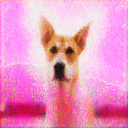

 77%|███████▋  | 2300/3000 [3:08:51<10:36,  1.10it/s]

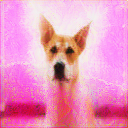

 80%|████████  | 2400/3000 [3:10:27<11:51,  1.19s/it]

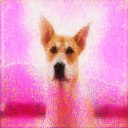

 83%|████████▎ | 2500/3000 [3:12:30<07:41,  1.08it/s]

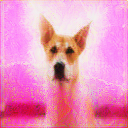

 87%|████████▋ | 2600/3000 [3:14:27<06:56,  1.04s/it]

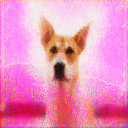

 90%|█████████ | 2700/3000 [3:16:20<05:35,  1.12s/it]

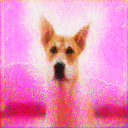

 93%|█████████▎| 2800/3000 [3:18:10<04:10,  1.25s/it]

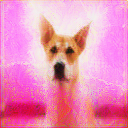

 97%|█████████▋| 2900/3000 [3:20:29<02:37,  1.57s/it]

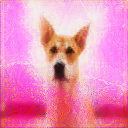

100%|██████████| 3000/3000 [3:23:35<00:00,  4.07s/it]


In [20]:
import torch
import torch.nn as nn
from torchvision import transforms, models
from PIL import Image
from tqdm import tqdm

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
imsize = 224 if torch.cuda.is_available() else 128  # use small size if no GPU

class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        self.chosen_features = ["0", "5", "10", "19", "28"]
        self.model = models.vgg19(pretrained=True).features[:29].eval()  # pretrained model
    
    def forward(self, x):
        features = []  # list of features
        for layer_num, layer in enumerate(self.model):
            x = layer(x)  # forward pass
            if str(layer_num) in self.chosen_features:  # if layer is in chosen features
                features.append(x)
        return features
    
class SoftClamp(nn.Module):
    def forward(self, image):
        return (torch.tanh(3 * image - 1.5) + 1) / 2.0

# Preprocessing and Deprocessing
def load_image(file_path):
    image = Image.open(file_path).convert("RGB")  # Open image and ensure it's RGB
    image = loader(image).unsqueeze(0)  # add the batch dimension
    return image.to(device)  # use GPU if available

def save_image(tensor, file_name):
    folder = "/Users/samarthuday/Desktop/Git/Art_Style/images/generated/"
    os.makedirs(folder, exist_ok=True)  # Create the folder if it doesn't exist
    file_path = os.path.join(folder, file_name)  # Full path for the file
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)  # remove the fake batch dimension
    image = unloader(image)  # convert tensor to PIL image
    image.save(file_name)
    print(f"Image saved at: {file_path}")

def show_image(tensor):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)  # remove the fake batch dimension
    image = unloader(image)  # convert tensor to PIL image
    display(image)
    # Convert PIL image to NumPy array for plotting
    #return np.array(image)

# Image transformations (similar to PyTorch approach)
loader = transforms.Compose([
    transforms.Resize((imsize, imsize)),  # resize image
    transforms.ToTensor(),  # convert image to Tensor
])

unloader = transforms.Compose([
    SoftClamp(),  # clamp image values for better visualization
    transforms.ToPILImage()  # convert Tensor to PIL Image
])

# Function to calculate Gram matrix for style loss
def gram_matrix(tensor):
    batch_size, channel, height, width = tensor.size()
    features = tensor.view(channel, height * width)
    G = torch.mm(features, features.t())  # Gram matrix
    return G / (channel * height * width)

# Load images
content_file = "/Users/samarthuday/Desktop/Git/Art_Style/content/dog.png" 
style_file = "/Users/samarthuday/Desktop/Git/Art_Style/style/ab4.jpeg" 

content_img = load_image(content_file)  # 1x3 x img_size x img_size tensor
style_img = load_image(style_file)  # 1x3 x img_size x img_size tensor

# Display the content and style images
print("Content Image:")
show_image(content_img)

print("Style Image:")
show_image(style_img)

# Initialize generated image (start with content image)
generated_img = content_img.clone()  # Initialize generated image as content image
generated_img.requires_grad_(True)  # Enable gradient computation

# Hyperparameters
total_steps = 3000  # Total number of steps for optimization
lr = 0.0005  # Learning rate
alpha = 1  # Weight for content loss
beta = 0.1  # Weight for style loss
optimizer = torch.optim.Adam([generated_img], lr=lr)

vgg = VGG().to(device)  # Pretrained VGG19 model

# Get style and content features
content_features = vgg(content_img)
style_features = vgg(style_img)

# Store images for visualization after training
stored_images = []

# Training loop
for step in tqdm(range(total_steps)):
    generated_img_features = vgg(generated_img)  # Features of generated image
    content_img_features = vgg(content_img)
    style_img_features = vgg(style_img)

    style_loss = content_loss = 0
    # Loop through all the features
    for gen_feature, content_feature, style_feature in zip(generated_img_features, content_img_features, style_img_features):
        
        batch_size, channel, height, width = gen_feature.shape  # Batch size = 1
        content_loss += torch.mean((gen_feature - content_feature) ** 2)  # Content loss

        # Compute Gram Matrix
        G = gen_feature.view(channel, height * width).mm(gen_feature.view(channel, height * width).t())
        A = style_feature.view(channel, height * width).mm(style_feature.view(channel, height * width).t())
        style_loss += torch.mean((G - A) ** 2)  # Style loss
    
    total_loss = alpha * content_loss + beta * style_loss  # Total loss
    optimizer.zero_grad()
    total_loss.backward()  # Backpropagate the loss
    optimizer.step()  # Update the image

    if step % 100 == 0:
        show_image(generated_img)  # Show the generated image every 100 steps
        
# Get the name of latest generated image
save_image(generated_img, "generated2.png")
